# Hurricane Harvey Before and After Analysis- Python

The destruction caused by the hurricane Harvey is analyzed using Landsat data.

I have done this project as a part of my course work for "Python Foundation for Spatial Analysis" conducted by Spatial Thoughts organization. The study area selected is Houstan city in Texas, USA. 


For this study the data used is Landsat 8-9 OLI/TIRS Collection 2 Level 2.
The Landsat image is taken from two dates of occurances.
The before data from 26 August 2017, which is taken as 20170524 and the after data from  29 September 2017  which is taken as 20170929.

To identify the urban area different indexes are used. In this case the index used are NDBI and NDVI.


In [2]:
# import all the necessary modules

import os
import rasterio
import numpy as np
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from glob import glob
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

ImportError: cannot import name '_docstring' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\Gokul G\miniconda3\envs\auto-gis\lib\site-packages\matplotlib\__init__.py)

The Landsat data to be used is opened from it's path. The data used contains two scenes to complete the area. Different scenes are defined based on their path and row, In this case;
- Path: 025 • Row: 039
- Path: 025 • Row: 040

In [ ]:
# define input path

data_path = "harvey"

before_band5 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B5.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B5.TIF"]
before_band6 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B6.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B6.TIF"]
before_band7 = ["LC08_L2SP_025040_20170524_20200903_02_T1_SR_B7.TIF",
                "LC08_L2SP_025039_20170524_20200903_02_T1_SR_B7.TIF"]

after_band5 = ["LC08_L2SP_025040_20170929_20200903_02_T1_SR_B5.TIF",
                "LC08_L2SP_025039_20170929_20200903_02_T1_SR_B5.TIF"]
after_band6 = ["LC08_L2SP_025040_20170929_20200903_02_T1_SR_B6.TIF",
                "LC08_L2SP_025039_20170929_20200903_02_T1_SR_B6.TIF"]
after_band7 = ["LC08_L2SP_025040_20170929_20200903_02_T1_SR_B7.TIF",
                "LC08_L2SP_025039_20170929_20200903_02_T1_SR_B7.TIF"]


The merge function is defined to merge the different scenes.

In [ ]:
def merge(fp):
    datasets = []
    for tile in fp:
        file = os.path.join(data_path, tile)
        datasets.append(rxr.open_rasterio(file, mask_and_scale=True))
    return merge_arrays(datasets)


The different bands containing different scenes from before data is merged into one image. 

In [ ]:
merged_before_band5 = merge(before_band5)
merged_before_band5

merged_before_band6 = merge(before_band6)
merged_before_band6

merged_before_band7 = merge(before_band7)
merged_before_band7

The different bands containing different scenes from after data is merged into one image. 

In [ ]:
merged_after_band5 = merge(after_band5)
merged_after_band5

merged_after_band6 = merge(after_band6)
merged_before_band6

merged_after_band7 = merge(after_band7)
merged_after_band7

The merged bands are saved and opened to stack the data one over the other.

In [ ]:
merged_before_band5.rio.to_raster(os.path.join("harvey", "outputs", "band5_before.tif"), compress="LZW")

merged_before_band6.rio.to_raster(os.path.join("harvey", "outputs", "band6_before.tif"), compress="LZW")

merged_before_band7.rio.to_raster(os.path.join("harvey", "outputs", "band7_before.tif"), compress="LZW")

merged_after_band5.rio.to_raster(os.path.join("harvey", "outputs", "band5_after.tif"), compress="LZW")

merged_after_band6.rio.to_raster(os.path.join("harvey", "outputs", "band6_after.tif"), compress="LZW")

merged_after_band7.rio.to_raster(os.path.join("harvey", "outputs", "band7_after.tif"), compress="LZW")

The glob function is used to group the similar bands together. 
This is done to stack the data together, which is needed for the index calculation. The extent of study area is read using a shapefiile.

In [6]:
shp_path = os.path.join("harvey", "aoi_n.shp")
before =  "*before*.TIF"
after = "*after*.TIF"

before_path = os.path.join( "harvey", "outputs", "data", before)
before_band_path = glob(before_path)
print(before_band_path)

after_path = os.path.join("harvey", "outputs","data", after)
after_band_path = glob(after_path)
print(after_band_path)


aoi = gpd.read_file(shp_path)

['harvey\\outputs\\data\\band5_before.tif', 'harvey\\outputs\\data\\band6_before.tif', 'harvey\\outputs\\data\\band7_before.tif']
['harvey\\outputs\\data\\band5_after.tif', 'harvey\\outputs\\data\\band6_after.tif', 'harvey\\outputs\\data\\band7_after.tif']


To cut the Landsat data up to the extent of the Area of Interest, the projection of both data is checked. And the area of interst is projected to the coordinate system of the Landsat data.

In [44]:
for data in before_band_path:
    landsat_crs = es.crs_check(data)
    aoi_utm = aoi.to_crs(landsat_crs)

CRS.from_epsg(32615)

Two functions are defined to read the different bands of data. Both of them are clubbed together one through the other.

- The open_clean_band function is used clip the given bands to the area of interest.

- The process_bands function is defined to stack all the clipped bands together one over the other.

In [2]:
# stacking and cropping the band

def open_clean_band(band_path, crop_layer=None):
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()

    return cleaned_band

def process_bands(paths, crop_layer=None, stack=False):
    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands


The Landsat data is stacked using the predefined functions. The stack contains.
- band_clip[0] = Band 4
- band_clip[1] = band 5
- band_clip[2] = Band 6 

The images are stacked for before and after data.


In [10]:
before_band_clip = process_bands(before_band_path, crop_layer=aoi_utm, stack=True)

I'm stacking your data now.


In [11]:
after_band_clip = process_bands(after_band_path, crop_layer=aoi_utm, stack=True)


I'm stacking your data now.


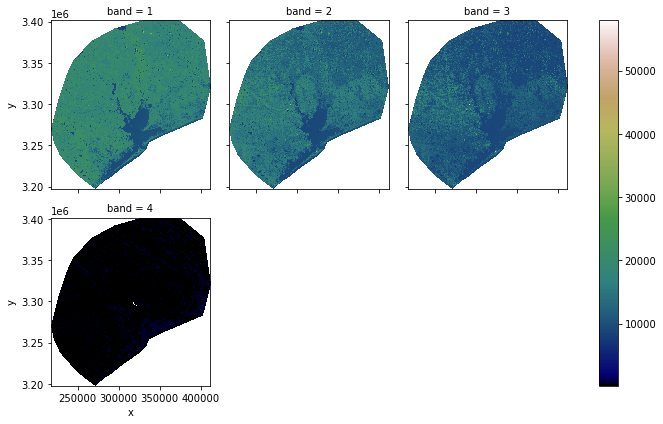

In [16]:

before_band_clip.plot.imshow( col="band", col_wrap = 3,
                            cmap="gist_earth")
#ax.set_axis_off()

plt.show()

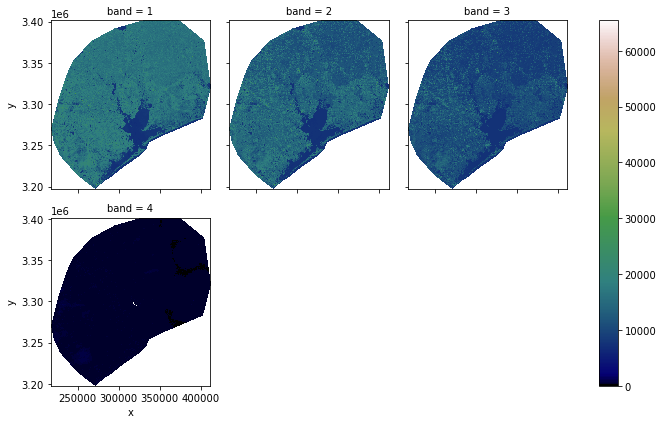

In [17]:
after_band_clip.plot.imshow( col="band", col_wrap = 3,
                            cmap="gist_earth")
#ax.set_axis_off()

plt.show()

### Normal Difference Built-up Index(NDBI)

NDBI = (SWIR – NIR) / (SWIR + NIR)

For Landsat 8 data, NDBI = (Band 6 – Band 5) / (Band 6 + Band 5)

NDBI is calculated for before and after data.


In [22]:
before_ndbi = es.normalized_diff( before_band_clip[2], before_band_clip[1])


In [23]:
after_ndbi = es.normalized_diff( after_band_clip[2], after_band_clip[1])


The difference is calculated to identify the difference between the images.

In [ ]:
difference = before_ndbi - after_ndbi

In order to distinguish change in urban pixels from other variations of lands, I reclassified the NDBI difference image into two classes.


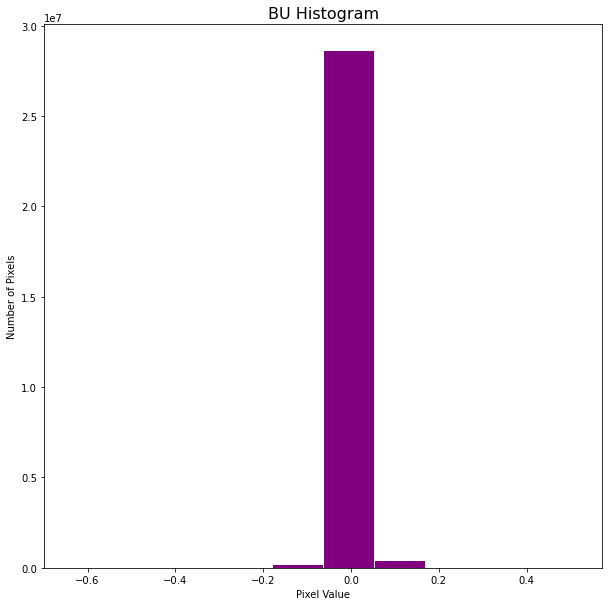

In [25]:
# Plot a histogram of the BU difference image

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(difference.ravel(),
        color='purple',
        edgecolor='white')
ax.set_title("BU Histogram",
             fontsize=16)
ax.set(xlabel="Pixel Value",
       ylabel="Number of Pixels")

plt.show()

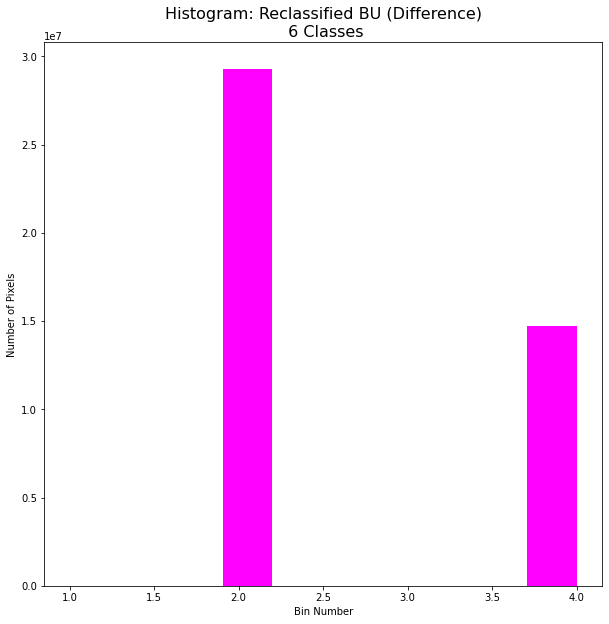

In [26]:
counts, bins, patches = ax.hist(difference.ravel(),
                                color='springgreen',
                                bins=3)
class_bins = bins

ndbi_class = np.digitize(difference, class_bins)
np.unique(ndbi_class)

#bins

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(ndbi_class.ravel(),
        color='magenta',
        edgecolor='white')
ax.set_title("Histogram: Reclassified BU (Difference)\n 2 Classes",
             fontsize=16)
ax.set(xlabel="Bin Number",
       ylabel="Number of Pixels")
plt.show()

[-1000.     0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.]
[-1000.     0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.]


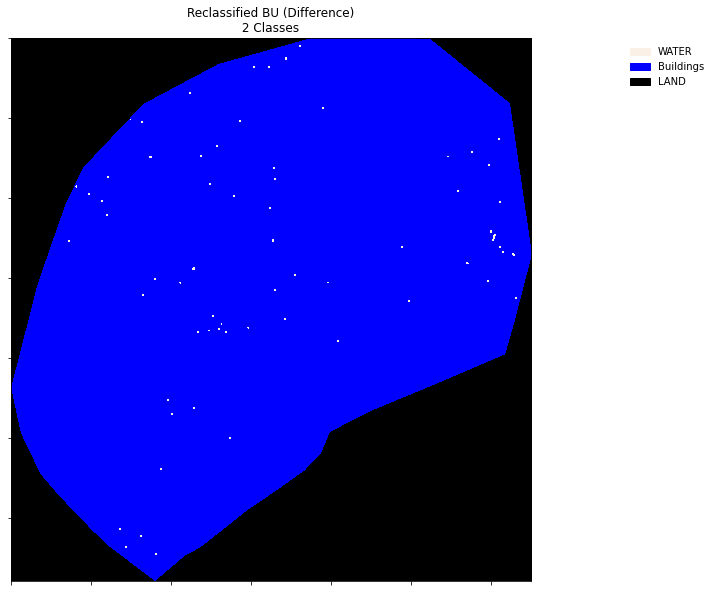

In [43]:
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['linen', 'blue', 'black']
class_labels1 = [ "Change ", "No change","NA"]
legend_patches1 = [Patch(color=icolor, label=label) for icolor, label in zip(colors, class_labels1)]
cmap = ListedColormap(colors)



ax.imshow(ndbi_class,cmap=cmap)

ax.legend(handles=legend_patches1,facecolor='white', edgecolor='white', bbox_to_anchor=(1.35, 1))

ax.set_title("Reclassified BU (Difference)\n 2 Classes ")
ax.set_axis_off

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

### Reference

- https://earthlab.colorado.edu/blog/assessing-extent-flood-event-using-python-change-detection-approach-landsat-imagery
- https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html